# Rip-off ETF?

An article in a recent issue of  *The Economist* suggests, right in the title, "[Investors should avoid a new generation of rip-off ETFs](https://www.economist.com/finance-and-economics/2024/08/22/investors-should-avoid-a-new-generation-of-rip-off-etfs)".
An exchange-traded fund (ETF) is an investment fund that holds a collection of assets, and trades on a stock exchange like a single stock. For example, the SPDR S&P 500 ETF Trust (SPY) tracks the S&P 500 index, but unlike traditional index funds, you can buy or sell shares in minutes.

There's nothing obviously wrong with that -- but as an example of a "rip-off ETF", the article describes "defined-outcome funds" or buffer ETFs, which "offer investors an enviable-sounding opportunity: hold stocks, with protection against falling prices. All they must do is forgo annual returns above a certain level, often 10% or so."

That might sound like a good deal, but the article explains, "Over the long term, they are a terrible deal for investors. Much of the compounding effect of stock ownership comes from rallies."

To demonstrate, they use the value of the S&P index since 1980: "An investor with returns capped at 10% and protected from losses would have made a real return of 403% over the period, a fraction of the 3,155% return offered by just buying and holding the S&P 500."

So that sounds bad, but returns from 1980 to the present have been historically unusual -- and as we've been warned, past performance is not indicative of future results.
To get a better sense of whether buffer ETFs are more generally a bad deal, let's get a bigger picture. 

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/examples/ripoff_etf.ipynb)

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

In [2]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

## The Dow Jones

The MeasuringWorth Foundation has compiled the value of the Dow Jones Industrial Average at the end of each day from February 16, 1885 to the present, with adjustments at several points to make the values comparable.
The series I collected starts on February 16, 1885 and ends on August 30, 2024.
The following cells download and read the data.

In [4]:
# "Citation: Samuel H. Williamson, 'Daily Closing Value of the Dow Jones Average, 1885 to Present,'
# MeasuringWorth, 2022. "

# Downloaded from https://www.measuringworth.com/datasets/DJA, September 3, 2024

In [5]:
DATA_PATH = "https://github.com/AllenDowney/ThinkStats/raw/v3/data/"
filename = "DJA.csv"
download(DATA_PATH + filename)

In [6]:
djia = pd.read_csv(filename, skiprows=4, parse_dates=[0], index_col=0)
djia.head()

,DJIA
Date,
1885-02-16,30.9226
1885-02-17,31.3365
1885-02-18,31.4744
1885-02-19,31.6765
1885-02-20,31.4252


To compute annual returns, we'll start by selecting the closing price on the last trading day of each year (dropping 2024 because we don't have a complete year).

In [7]:
annual = djia.groupby(djia.index.year).last().drop(2024)
annual

,DJIA
Date,
1885,39.4859
1886,41.2391
1887,37.7693
1888,39.5866
1889,42.0394
...,...
2019,28538.4400
2020,30606.4800
2021,36338.3000


Next we'll compute the annual price return, which is the ratio of successive year-end closing prices.

In [8]:
annual['Ratio'] = annual['DJIA'] / annual['DJIA'].shift(1)
annual

,DJIA,Ratio
Date,,
1885,39.4859,NaN
1886,41.2391,1.044401
1887,37.7693,0.915861
1888,39.5866,1.048116
1889,42.0394,1.061960
...,...,...
2019,28538.4400,1.223384
2020,30606.4800,1.072465
2021,36338.3000,1.187275


And the relative return as a percentage.

In [9]:
annual['Return'] = (annual['Ratio'] - 1) * 100

Looking at the years with the biggest losses and gains, we can see that most of the extremes were before the 1960s -- the exception is the 2008 financial crisis.

In [10]:
annual.dropna().sort_values(by='Return')

,DJIA,Ratio,Return
Date,,,
1931,77.9000,0.473326,-52.667396
1907,43.0382,0.622683,-37.731743
2008,8776.3900,0.661629,-33.837097
1930,164.5800,0.662347,-33.765293
1920,71.9500,0.670988,-32.901240
...,...,...,...
1954,404.3900,1.439623,43.962264
1908,63.1104,1.466381,46.638103
1928,300.0000,1.482213,48.221344


Here's what the distribution of annual returns looks like.

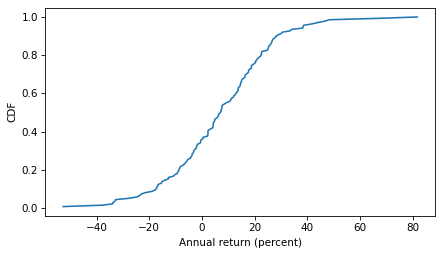

In [11]:
from empiricaldist import Cdf

cdf_return = Cdf.from_seq(annual['Return'])
cdf_return.plot()

decorate(xlabel='Annual return (percent)', ylabel='CDF')

Immediately we see why capping returns at 10% might be a bad idea -- this cap is exceeded almost 45% of the time, and sometimes by a lot!

In [12]:
1 - cdf_return(10)

0.4492753623188406

We'll use the following function to compute long-term returns.
It takes a start date and a duration, and computes two ratios:

* The total price return based on actual annual returns.

* The total price return if annual returns are clipped at 0 and 10 -- that is, any negative returns are set to 0 and any returns above 10 are set to 10.

In [13]:
def compute_ratios(start=1993, duration=30):
    end = start + duration
    interval = annual.loc[start: end]
    ratio = interval['Ratio'].prod()
    low, high = 1.0, 1.10
    clipped = interval['Ratio'].clip(low, high)
    ratio_clipped = clipped.prod()
    return start, end, ratio, ratio_clipped

With this function, we can replicate the analysis *The Economist* did with the S&P 500.
Here are the results for the DJIA from the beginning of 1980 to the end of 2023.

In [14]:
compute_ratios(1980, 43)

(1980, 2023, 44.93751117788029, 15.356490985533199)

A buffer ETF over this period would have grown by a factor of more than 15 in nominal dollars, with no risk of loss.
But an index fund would have grown by a factor of almost 50.
So yeah, the ETF would have been a bad deal.

However, if we go back to the bad old days, an investor in 1900 would have been substantially better off with a buffer ETF held for 43 years -- a factor of 7.2 compared to a factor of 2.8.

In [15]:
compute_ratios(1900, 43)

(1900, 1943, 2.8071864303140583, 7.225624631784611)

It seems we can cherry-pick the data to make the comparison go either way -- so let's see how things look more generally.
Starting in 1886, we'll compute price returns for all 30-year intervals, ending with the interval from 1993 to 2023.

In [16]:
ratios = [compute_ratios(start, 30) for start in range(1886, 1993+1)]
ratios = pd.DataFrame(ratios, columns=['Start', 'End', 'Index Fund', 'Buffer ETF'])
ratios.index = ratios['Start']

Here's what the returns look like for an index fund compared to a buffer ETF.

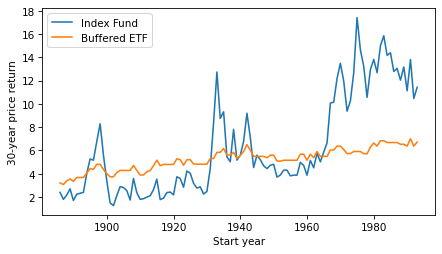

In [17]:
ratios['Index Fund'].plot()
ratios['Buffer ETF'].plot()

decorate(xlabel='Start year', ylabel='30-year price return')

The buffer ETF performs as advertised, substantially reducing volatility.
But it has only occasionally been a good deal, and not in my lifetime.

According to ChatGPT, the primary reasons for strong growth in stock prices since the 1960s are "technological advancements, globalization, financial market innovation, and favorable monetary policies".
If you think these elements will generally persist over the next 30 years, you might want to avoid buffer ETFs. 